In [12]:
import warnings
warnings.simplefilter("ignore", UserWarning)
import numpy as np 
import pickle
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import utils
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import QuantileTransformer, RobustScaler 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import lightgbm as lgb 
import optuna
from optuna.samplers import TPESampler 
from sklearn.pipeline import make_pipeline, Pipeline

This notebook attemps to show an overview of how a model is trained after preprocessing and how the model is evaluated. In the end, there will be a summary section summarising the ablation studies, follow by a future work section to discuss about potential work that could be done to improve the model. 

# Content
1. Feature Encoding
    - 1.1 Group By Features
2. Model Training
    - 2.1 Hyperparameter Tuning
    - 2.2 Robustness of Hyperparameter
3. Training
4. Evaluation
    - 4.1 Feature Importance
    - 4.2 Residual Analyses
5. Summary
6.. Future Work

---

# 1. Feature Encoding 

In [13]:
# load preprocessed data set 
df = pd.read_csv('dummies_ds.csv')
# create a copy
df_ = df.copy()
df.head()

,Make,Model,YearGroup,MonthGroup,SequenceNum,CurrentRelease,LimitedEdition,Series,SeriesModelYear,BadgeDescription,...,VFactsSegment,VFactsPrice,IsPPlateApproved,NewPrice,Colour,Branch,SaleCategory,Age_Comp_Months,KM,Sold_Amount
0,Holden,Commodore,2008,0,0,F,F,VE,MY10,Omega,...,Large,< 70K,T,0.804271,white,Perth (WA),Auction,0.692098,0.823427,2000.0
1,Holden,Commodore,1993,7,41,F,F,VR,MY10,Executive,...,Large,< 70K,T,0.801763,red,Belmore (NSW),Auction,0.689494,0.819703,6800.0
2,Toyota,RAV4,2012,0,6,F,F,ACA33R,MY12,CV,...,Medium,< 60K,T,0.803314,white,Sunshine (VIC),Dealer Only Auction,0.616122,0.801508,22900.0
3,Holden,Commodore,2007,0,11,F,F,VZVE,MY07,Executive,...,Large,< 70K,T,0.804656,silver,Belmore (NSW),Auction,0.668197,0.815478,10500.0
4,Toyota,Tarago,2007,0,0,F,F,ACR50R,MY10,GLi,...,People Movers,< 60K,T,0.808189,silver,Hobart (TAS),Special Fixed Price,0.644951,0.806989,31320.0


Since the model we have chosen can take 'category' type as input. We do not need to do any feature encoding for categorical data at this stage

In [14]:
categorical_col_idx = np.where(df.dtypes == object)[0]
cols_name = [name for name in df.columns]
categorical_cols = [cols_name[i] for i in categorical_col_idx] + ['YearGroup',
 'MonthGroup',
 'SequenceNum',
 'GearNum',
 'DoorNum',
 'FuelCapacity',
 'SeatCapacity',
 'ValvesCylinder',
 'TowingNoBrakes', # to  be observed
 'WarrantyYears',
 'FirstServiceKM',
 'RegServiceMonths',
 'WarrantyKM']
df[categorical_cols] = df[categorical_cols].astype('category')

## 1.1 Group By Features
In this section, we veunture on the numeircal columns that can be aggregated as new features

In [15]:
numerical_col = ['EngineSize', 'GrossCombinationMAss',
'WheelBase', 'Height', 'Width', 'Power', 'PowerRPMTo',
'Torque', 'TorqueRPMTo', 'RonRating', 'Acceleration',
'GreenhouseRating','AirpollutionRating', 'AncapRating',
'NewPrice', 'Age_Comp_Months', 'KM']

# 'Width', 'PayLoad' ...

# group by function to be load into .agg()
features = {k: [np.sum, np.mean, np.std, np.min, np.max] for k in numerical_col}

def flatten_name(prefix, src_names):
    """
    Helper function for column naming after 
    aggregation
    """
    ret = []
    for c in src_names:
        if c[0] in ['Make', 'Model']:
            ret.append(c[0])
        else:
            ret.append('.'.join([prefix] + list(c)))
    return ret

agg = df[['EngineSize', 'GrossCombinationMAss',
'WheelBase', 'Height', 'Width','Power', 'PowerRPMTo',
'Torque', 'TorqueRPMTo', 'RonRating', 'Acceleration',
'GreenhouseRating','AirpollutionRating', 'AncapRating',
'NewPrice', 'Age_Comp_Months', 'KM', 'Make']].groupby(['Make']).agg(features).reset_index(drop=False)
agg.columns = flatten_name('grouped', agg.columns)

In [16]:
# impute the aggregated features with mean values and left join on 'Make'
tmp_df = df.merge(agg.fillna(agg.mean()), how = 'left', on = ['Make'])
tmp_df

,Make,Model,YearGroup,MonthGroup,SequenceNum,CurrentRelease,LimitedEdition,Series,SeriesModelYear,BadgeDescription,...,grouped.Age_Comp_Months.sum,grouped.Age_Comp_Months.mean,grouped.Age_Comp_Months.std,grouped.Age_Comp_Months.amin,grouped.Age_Comp_Months.amax,grouped.KM.sum,grouped.KM.mean,grouped.KM.std,grouped.KM.amin,grouped.KM.amax
0,Holden,Commodore,2008,0,0,F,F,VE,MY10,Omega,...,9006.351738,0.657206,0.025825,0.352793,0.733992,11115.471415,0.811111,0.025349,0.0,0.838186
1,Holden,Commodore,1993,7,41,F,F,VR,MY10,Executive,...,9006.351738,0.657206,0.025825,0.352793,0.733992,11115.471415,0.811111,0.025349,0.0,0.838186
2,Toyota,RAV4,2012,0,6,F,F,ACA33R,MY12,CV,...,12802.847781,0.649166,0.031929,0.441230,0.758282,15928.905462,0.807672,0.020730,0.0,0.831473
3,Holden,Commodore,2007,0,11,F,F,VZVE,MY07,Executive,...,9006.351738,0.657206,0.025825,0.352793,0.733992,11115.471415,0.811111,0.025349,0.0,0.838186
4,Toyota,Tarago,2007,0,0,F,F,ACR50R,MY10,GLi,...,12802.847781,0.649166,0.031929,0.441230,0.758282,15928.905462,0.807672,0.020730,0.0,0.831473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61555,Ford,Ranger,2012,0,22,F,F,PX,MY10,XL,...,7729.941841,0.658764,0.024558,0.486000,0.756566,9522.671634,0.811545,0.025064,0.0,0.836287
61556,Ford,Falcon,2003,0,1,F,F,BA,MY10,XT,...,7729.941841,0.658764,0.024558,0.486000,0.756566,9522.671634,0.811545,0.025064,0.0,0.836287
61557,Ford,Falcon,2001,10,40,F,F,AU III,MY10,Futura,...,7729.941841,0.658764,0.024558,0.486000,0.756566,9522.671634,0.811545,0.025064,0.0,0.836287
61558,Mitsubishi,Lancer,2011,10,24,F,F,CJ,MY12,ES,...,2546.140973,0.658939,0.027948,0.352793,0.722971,3133.631084,0.810981,0.027780,0.0,0.830044


In [17]:
# save check to drop rows with NULL values
tmp_df.dropna(inplace=True)
print(tmp_df.isna().sum().sum())

0


---

# 2. Model Training
This section attempts to describe the model setup and how the model is being trained.

In [18]:
# define traget variable and features for train validation split 
# apply log(1+x) to target variable
Y = tmp_df.pop('Sold_Amount')
X = tmp_df
# sanity check
print("Number of traget tariables: ", Y.shape[0])
print("Dimension of features: ", X.shape)

Number of traget tariables:  61544
Dimension of features:  (61544, 149)


We create 5 fold cross validation for our data set

In [19]:
# number of folds
folds = 5
# seeding 
seed = 5243 
# initiate cross fold validation
cv = KFold(n_splits = folds, shuffle = True, random_state = seed)

## 2.1 Hyperparameter Tuning
In this work, we use state of the art method for regression problem, which is LightGBM by Microsoft. LightGBM is a tree-based method that adopted gradient boosting for learning, with more efficient training. Associated with LightGBM, optuna was chosen as the library for auto hyperparameter tuning.   

In [20]:
def objective(trial, X, Y, cv, folds):
    param_grid = {
    "objective": 'regression',
    "verbosity": -1, 
    "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
    "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
    "max_depth": trial.suggest_int("max_depth", 3, 12),
    }
    model = lgb.LGBMRegressor(**param_grid)
    # scaling the features 
    trans = QuantileTransformer(n_quantiles=100, output_distribution='normal')
    # build using sklearn pipeline
    pipeline = Pipeline(steps=[('t', trans), ('m', model)])
    # to minimise: loss function => RMSE
    cv_scores = - cross_val_score(model, X, Y, 
                                cv = cv, scoring = 'neg_root_mean_squared_error')
    with open("model_weights/{}.pickle".format(trial.number), "wb") as fout:
        pickle.dump(model, fout)
    return np.mean(cv_scores)

In [21]:
sampler = TPESampler(seed = 5243)
study = optuna.create_study(direction = "minimize", study_name = 'LGBM Regressor', 
                            sampler = sampler)
func = lambda trial: objective(trial, X, Y, cv, folds)
study.optimize(func, n_trials = 20)

[I 2022-02-13 22:33:17,741] A new study created in memory with name: LGBM Regressor
[I 2022-02-13 22:40:25,809] Trial 0 finished with value: 2510.618643594184 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17214024703062292, 'num_leaves': 3000, 'max_depth': 8}. Best is trial 0 with value: 2510.618643594184.
[I 2022-02-13 22:42:36,701] Trial 1 finished with value: 2480.1135238161964 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1371183438142015, 'num_leaves': 260, 'max_depth': 3}. Best is trial 1 with value: 2480.1135238161964.
[I 2022-02-13 22:46:52,248] Trial 2 finished with value: 2593.1296494747594 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27424659226897374, 'num_leaves': 500, 'max_depth': 6}. Best is trial 1 with value: 2480.1135238161964.
[I 2022-02-13 22:52:06,019] Trial 3 finished with value: 2466.733817039236 and parameters: {'n_estimators': 10000, 'learning_rate': 0.131657773354797, 'num_leaves': 2560, 'max_depth': 7}. Best is trial 3 

Best hyperparameters for LightGBM is trial 19 with RMSE of approximately 0.4857

In [22]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial no.:", study.best_trial.number)
trial = study.best_trial
print(" RMSE: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# load model
with open("model_weights/{}.pickle".format(study.best_trial.number), "rb") as fin:
    best_model = pickle.load(fin)

Number of finished trials: 20
Best trial no.: 19
 RMSE: 2387.7880820946125
  Params: 
    n_estimators: 10000
    learning_rate: 0.037596223750980796
    num_leaves: 1760
    max_depth: 6


In [68]:
# visualising the search pattern of the trials w.r.t objective value
optuna.visualization.plot_optimization_history(study)

In [24]:
# visualising the importance of hyperparamters 
optuna.visualization.plot_param_importances(study)

It is observed that parameter 'learning_rate' has the most impact on the model

 ## 2.1 Robustness of Hyperparameter
 This section attempts to validate if the best hyperparameter is robust,

First we check the performance of each fold for the best model

In [25]:
cv_scores = - cross_val_score(best_model, X, Y,
                              cv = cv, scoring = 'neg_root_mean_squared_error')
for i in range(cv_scores.shape[0]):
    print("Fold {} RMSE: {}".format(i, cv_scores[i]))
print("-"*50)
print("Mean: {}".format(np.mean(cv_scores)))
print("Std.: {}".format(np.std(cv_scores)))
print("Max.: {}".format(np.max(cv_scores)))
print("Min.: {}".format(np.min(cv_scores)))

Fold 0 RMSE: 2423.168514502875
Fold 1 RMSE: 2341.2581724256584
Fold 2 RMSE: 2423.8641326931556
Fold 3 RMSE: 2395.779481629595
Fold 4 RMSE: 2354.8701092217775
--------------------------------------------------
Mean: 2387.7880820946125
Std.: 34.25126077261895
Max.: 2423.8641326931556
Min.: 2341.2581724256584


From the results above, while some folds has higher RMSE values and some folds has lower RMSE values, the discrepancy isn't that large and we could consider the hyperparameters to be pretty solid

---

# 3. Training
Now that we have the best parameters for our model we can train our model with the parameters and validate it

In [39]:
numerical_columns = X.dtypes[X.dtypes != 'category'].index.to_list()
print(numerical_columns)

['EngineSize', 'GrossCombinationMAss', 'WheelBase', 'Height', 'Width', 'Power', 'PowerRPMTo', 'Torque', 'TorqueRPMTo', 'RonRating', 'Acceleration', 'GreenhouseRating', 'AirpollutionRating', 'AncapRating', 'NewPrice', 'Age_Comp_Months', 'KM', 'grouped.EngineSize.sum', 'grouped.EngineSize.mean', 'grouped.EngineSize.std', 'grouped.EngineSize.amin', 'grouped.EngineSize.amax', 'grouped.GrossCombinationMAss.sum', 'grouped.GrossCombinationMAss.mean', 'grouped.GrossCombinationMAss.std', 'grouped.GrossCombinationMAss.amin', 'grouped.GrossCombinationMAss.amax', 'grouped.WheelBase.sum', 'grouped.WheelBase.mean', 'grouped.WheelBase.std', 'grouped.WheelBase.amin', 'grouped.WheelBase.amax', 'grouped.Height.sum', 'grouped.Height.mean', 'grouped.Height.std', 'grouped.Height.amin', 'grouped.Height.amax', 'grouped.Width.sum', 'grouped.Width.mean', 'grouped.Width.std', 'grouped.Width.amin', 'grouped.Width.amax', 'grouped.Power.sum', 'grouped.Power.mean', 'grouped.Power.std', 'grouped.Power.amin', 'groupe

In [54]:
from sklearn.compose import ColumnTransformer
trans = QuantileTransformer(n_quantiles=100, output_distribution='normal')
scaler_x = ColumnTransformer([("num_x", trans, numerical_columns)])
# 80% training data set and 20% hold out samples
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
# fit numerical column into scaler function
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.fit_transform(x_test)

# load param from best trial
best_params = { 
    "objective": 'regression',
    "metric": "rmse",
    "verbosity": -1, 
    'n_estimators': 10000,
    'learning_rate': 0.037596223750980796,
    'num_leaves': 1760,
    'max_depth': 6,
    }
lgb_train = lgb.Dataset(x_train, label = y_train)
lgb_test = lgb.Dataset(x_test, label = y_test)
model = lgb.train(best_params, lgb_train, 5000, 
                  valid_sets = [lgb_train, lgb_test],
                 verbose_eval = 100, early_stopping_rounds = 400)
# save best model
with open("model_weights/best_model.pickle".format(trial.number), "wb") as fout:
    pickle.dump(model, fout)

Training until validation scores don't improve for 400 rounds
[100]	training's rmse: 3073.47	valid_1's rmse: 3353.25
[200]	training's rmse: 2881.48	valid_1's rmse: 3203.78
[300]	training's rmse: 2800.89	valid_1's rmse: 3159.95
[400]	training's rmse: 2742.63	valid_1's rmse: 3133.09
[500]	training's rmse: 2694.59	valid_1's rmse: 3113.68
[600]	training's rmse: 2655.84	valid_1's rmse: 3100.99
[700]	training's rmse: 2620.39	valid_1's rmse: 3092.2
[800]	training's rmse: 2585.92	valid_1's rmse: 3083.09
[900]	training's rmse: 2553.99	valid_1's rmse: 3078.22
[1000]	training's rmse: 2527.51	valid_1's rmse: 3073.03
[1100]	training's rmse: 2497.45	valid_1's rmse: 3072.39
[1200]	training's rmse: 2473.22	valid_1's rmse: 3070.36
[1300]	training's rmse: 2452.08	valid_1's rmse: 3068.65
[1400]	training's rmse: 2431	valid_1's rmse: 3067.69
[1500]	training's rmse: 2410.97	valid_1's rmse: 3068.54
[1600]	training's rmse: 2389.53	valid_1's rmse: 3068.35
[1700]	training's rmse: 2371.11	valid_1's rmse: 3067.79

It is observed that there is minor overfitting occurs with higher testing error than training error. There is a need to rethink strategy to counter overfitting.

---

# 4. Evaluation

Visualize the important feature and residual analysis of the predictive model

## 4.1 Feature Importance

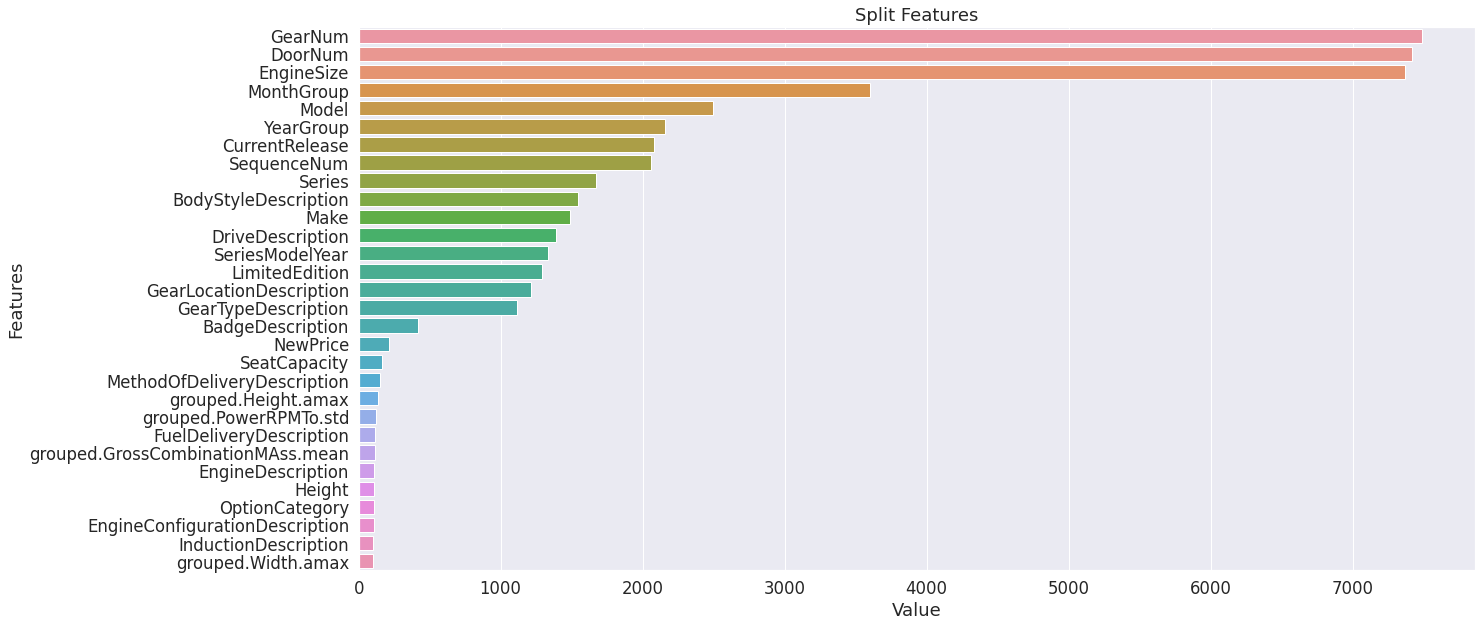

In [58]:
# retrive the importance for 'split'
feature_imp = model.feature_importance(importance_type = 'split')
# choose top 20 importance features
imp_df = pd.DataFrame(sorted(zip(feature_imp, X.columns), reverse = True)[:30], 
                      columns = ['Value', 'Features'])
plt.figure(figsize = (20, 10))
sns.set(font_scale = 1.5)
sns.barplot(x="Value", y="Features", data = imp_df)
plt.title('Split Features')
plt.show()

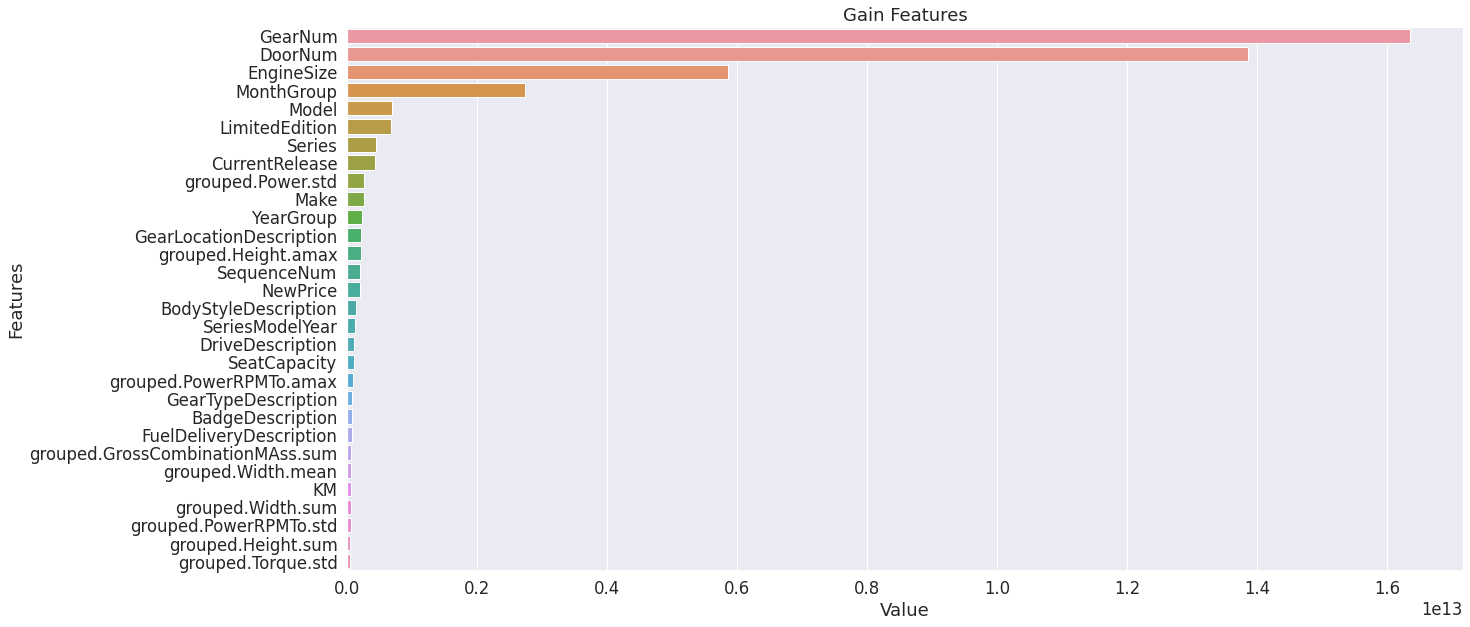

In [57]:
# retrive the importance for 'gain'
feature_imp = model.feature_importance(importance_type = 'gain')
# choose top 20 importance features
imp_df = pd.DataFrame(sorted(zip(feature_imp, X.columns), reverse = True)[:30], 
                      columns = ['Value', 'Features'])
plt.figure(figsize = (20, 10))
sns.set(font_scale = 1.5)
sns.barplot(x="Value", y="Features", data = imp_df)
plt.title('Gain Features')
plt.show()

In both feature importance, 'GearNum', 'DoorNum', 'MonthGroup', 'Model' are the top 4 most important features.

## 4.2 Residual Analyses
In this section, we attempt to analyse the error between the predicted value and the target value with MSE, RMSE and MAE. MAPE was not used for error analysis due to the nature of the original target values that has quite a number of 0 values which will yield very high MAPE errors due to the division of true target value in the denominator.

In [71]:
# revert back log(y+1) => exp(y)-1
Y_hat = model.predict(x_test)
Y_ = y_test
# MSE measures the variance of the residuals, sensitive to outliers 
mse = mean_squared_error(Y_, Y_hat)
# RMSE measures the standard deviation of the residuals, sensitive to outliers
rmse = mean_squared_error(Y_, Y_hat, squared = False)
# MAE measures the median of the residuals, more robust to outliers
mae = mean_absolute_error(Y_, Y_hat)
metrics = ['mse', 'rmse', 'mae']
metrics_val = [mse, rmse, mae]
residual_df = pd.DataFrame(zip(metrics, metrics_val), columns=['Metrics', 'Value'])
print("Errors in Actual Scale: ")
print(residual_df)

Errors in Actual Scale: 
  Metrics         Value
0     mse  9.408410e+06
1    rmse  3.067313e+03
2     mae  1.854018e+03


In [79]:
# statistical properties of the actual test data
print('Statistical properties of Predicted Data:')
print(Y_.describe())
print('-'*80)
print('Number of zeros: ', np.where(Y_.to_numpy()==0)[0].shape[0])

Statistical properties of Predicted Data:
count    12309.000000
mean     16300.066887
std       8652.396270
min          0.000000
25%      10670.000000
50%      15200.000000
75%      20600.000000
max      53250.000000
Name: Sold_Amount, dtype: float64
--------------------------------------------------------------------------------
Number of zeros:  164


In [80]:
# statistical properties of the predicted test data
print('Statistical properties of Predicted Data:')
Y_hat_df = pd.Series(Y_hat)
print(Y_hat_df.describe())
print('-'*80)
print('Number of zeros: ', np.where(Y_hat==0)[0].shape[0])
print('Number of negatives: ', np.where(Y_hat<0)[0].shape[0])

Statistical properties of Predicted Data:
count    12309.000000
mean     16219.469806
std       8098.968566
min       -645.398153
25%      10825.952370
50%      15072.796616
75%      20335.299188
max      55162.309183
dtype: float64
--------------------------------------------------------------------------------
Number of zeros:  0
Number of negatives:  2


As observed from our residual analyses, the predictive model has relatively high RMSE, MSE and MAE values. With high RMSE and MSE, this indicates outliers (see plot below). MAE of value ~1854 indicates that on average the prediced price is overestimated or underestimated by $1854.  
By comparing the statistical properties of the predicted data and actual data, we can observed that there are 2 negative values in the predicted price. Considerating that there is no zeros in the predicted data and 164 zeros in the actual data, this might be source of the contribution of high errors.   

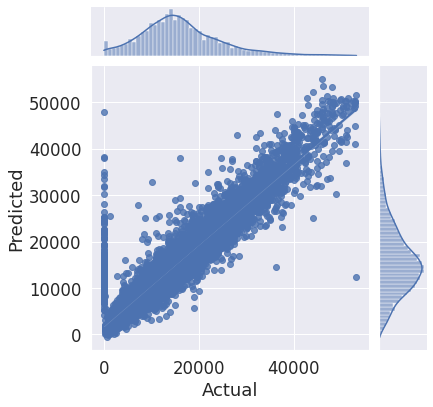

In [60]:
joint_df = pd.DataFrame(zip(Y_, Y_hat), columns=['Actual', 'Predicted'])
sns.jointplot(data=joint_df, x='Actual', y='Predicted', kind='reg')

---

# 5. Summary 

In a nutshell, this work presented the workflow for data preparation, model training and evaluation for vehicle sale prices. In the first part of the notebook, data understanding and data preprocessing was implemented to prepare the data set for model training. In the second part of the notebook, lightGBM was adopted to solve regression task. To boost the model performance, hyperparameter tuning was applied on 5 fold cross validation. The robustness of the fine tuned parameters was validated before training the model. In the evaluation section, residual analyses was validated with metrics such as MSE, RMSE and MAE. At the end of the experiment, the follow metric scores were achieved.  
-     MSE:  9.408410e+06
-    RMSE:  3.067313e+03
-     MAE:  1.854018e+03  
Improvements that could be done will be discussed in the next section.

---

# 6. Future Work

- Quantile transformation was part of the preproceesing pipeline but not used during parameter tuning because the data set consisted of mixed numerical and category data type. There is a need to write better pipeline to take quantile transformation into consideration.
- Setting up baseline models, such as decision tree or random forest to compare the robustness of applied model.
- Using ensemble learning techniques (stacking) to improve predictions.
- using meta-labeling methods with K-NN for feature engineering.
- Define higher number of trials for hyperparameter tuning.
- Manage experiments with MLFlow. 